Created: 2020.08.24

Modified: 2020.08.24

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
from fastai.core import parallel

In [3]:
import glob
import nibabel as nib
import pandas as pd
import numpy as np
import imageio as io
from pathlib import Path
import matplotlib.pyplot as plt
from fastai.core import parallel

from sklearn.metrics import jaccard_score
from scipy.spatial.distance import directed_hausdorff

In [4]:
MAIN_PTH = Path(f'/data-10tb/shared/skull/al-image/')

IMAGE_PTH = MAIN_PTH / 'image'
AXIAL_PTH = MAIN_PTH / 'axial-2d'
SAGITTAL_PTH = MAIN_PTH / 'sagittal-2d'
CORONAL_PTH = MAIN_PTH / 'coronal-2d'


IMAGE_PTH.mkdir(parents=True, exist_ok=True)
AXIAL_PTH.mkdir(parents=True, exist_ok=True)
SAGITTAL_PTH.mkdir(parents=True, exist_ok=True)
CORONAL_PTH.mkdir(parents=True, exist_ok=True)

IMAGE_T1 = IMAGE_PTH / 'T1.nii.gz'
IMAGE_BIAS = IMAGE_PTH / 'T1_biascorr.nii.gz'
IMAGE_MSK = IMAGE_PTH / 'T1_biascorr_brain_mask.nii.gz'

### Split 3D image into 2D slices

#### Axial / Coronal / Sagittal

In [5]:
split = 0

if split:
    axial = 0
    coronal = 0
    sagittal = 1

    # 3D image file name ¤# T1 / T1_biascorr / T1_biascorr_brain_mask
    name = "T1_biascorr_brain_mask"
    image = IMAGE_MSK

    if axial:    
        filename = AXIAL_PTH / name    
        im3d = nib.load(image).get_fdata()
        sl = im3d.shape[2] 

    if coronal:    
        filename = CORONAL_PTH / name    
        im3d = nib.load(image).get_fdata()
        sl = im3d.shape[1] 

    if sagittal:
        filename = SAGITTAL_PTH / name    
        im3d = nib.load(image).get_fdata()
        sl = im3d.shape[0] 


    # T1 or MASK image
    if 'mask' in str(filename):
        mask = True
        im3d = im3d.astype(np.uint8)
    else:
        mask = False
        ### STANDARYZACJA
        im3d -= im3d.mean()
        im3d /= im3d.std()  


    for k in range(sl):
        filename_png = f'{filename}_{k:03}.png'
        path_png = AXIAL_PTH/filename_png

        if not path_png.exists():
            if mask:
                if axial:
                    io.imsave(path_png, np.where(im3d[:,:,k]>=1, 1, 0).astype(np.uint8))
                if coronal:
                    io.imsave(path_png, np.where(im3d[:,k,:]>=1, 1, 0).astype(np.uint8))
                if sagittal:
                    io.imsave(path_png, np.where(im3d[k,:,:]>=1, 1, 0).astype(np.uint8))
            else:
                if axial:
                    plt.imsave(path_png, im3d[:,:,k], cmap='gray')
                if coronal:
                    plt.imsave(path_png, im3d[:,k,:], cmap='gray')
                if sagittal:
                    plt.imsave(path_png, im3d[k,:,:], cmap='gray')

    print('Done')

### Create df for testing

In [6]:
PLANE = AXIAL_PTH
PLANE_NAME = 'axial'
IMAGET_TYPE = 't1' # t1 OR bias # not utse yet

t1_pth = sorted(glob.glob(f'{PLANE}/T1_[0-9]*.png'))
bias_pth = sorted(glob.glob(f'{PLANE}/T1_biascorr_[0-9]*.png'))
msk_pth = sorted(glob.glob(f'{PLANE}/T1_biascorr_brain_mask*.png'))

t1_pth = [Path(p) for p in t1_pth] 
bias_pth = [Path(p) for p in bias_pth] 
msk_pth = [Path(p) for p in msk_pth] 

root = [p.parent for p in t1_pth] 
t1_list = [p.name for p in t1_pth] 
bias_list = [p.name for p in bias_pth]
print(len(root), len(t1_list), len(bias_list))

181 181 181


In [7]:
df_test = pd.DataFrame.from_dict({'root':root, 't1':t1_list, 'bias':bias_list, 'msk':msk_pth})
df_test['usage'] = True
print(df_test.shape)
df_test.head()

(181, 5)


,root,t1,bias,msk,usage
0,/data-10tb/shared/skull/al-image/axial-2d,T1_000.png,T1_biascorr_000.png,/data-10tb/shared/skull/al-image/axial-2d/T1_b...,True
1,/data-10tb/shared/skull/al-image/axial-2d,T1_001.png,T1_biascorr_001.png,/data-10tb/shared/skull/al-image/axial-2d/T1_b...,True
2,/data-10tb/shared/skull/al-image/axial-2d,T1_002.png,T1_biascorr_002.png,/data-10tb/shared/skull/al-image/axial-2d/T1_b...,True
3,/data-10tb/shared/skull/al-image/axial-2d,T1_003.png,T1_biascorr_003.png,/data-10tb/shared/skull/al-image/axial-2d/T1_b...,True
4,/data-10tb/shared/skull/al-image/axial-2d,T1_004.png,T1_biascorr_004.png,/data-10tb/shared/skull/al-image/axial-2d/T1_b...,True


### df for training

In [8]:
df_train = df_test.iloc[:3*4, :].copy(deep=True)
df_train['usage'] = df_train['usage'].replace(True,False)
df_train.head()

,root,t1,bias,msk,usage
0,/data-10tb/shared/skull/al-image/axial-2d,T1_000.png,T1_biascorr_000.png,/data-10tb/shared/skull/al-image/axial-2d/T1_b...,False
1,/data-10tb/shared/skull/al-image/axial-2d,T1_001.png,T1_biascorr_001.png,/data-10tb/shared/skull/al-image/axial-2d/T1_b...,False
2,/data-10tb/shared/skull/al-image/axial-2d,T1_002.png,T1_biascorr_002.png,/data-10tb/shared/skull/al-image/axial-2d/T1_b...,False
3,/data-10tb/shared/skull/al-image/axial-2d,T1_003.png,T1_biascorr_003.png,/data-10tb/shared/skull/al-image/axial-2d/T1_b...,False
4,/data-10tb/shared/skull/al-image/axial-2d,T1_004.png,T1_biascorr_004.png,/data-10tb/shared/skull/al-image/axial-2d/T1_b...,False


#### Concatenate both df's

In [9]:
df_main = pd.concat([df_train, df_test])
print(df_main.shape)
df_main.head(15)

DF_PTH = f'{MAIN_PTH}/{PLANE_NAME}.csv'
df_main.to_csv(DF_PTH)

(193, 5)


### Create a loader

In [10]:
# item list
il = SegmentationItemList.from_df(df_main, PLANE, cols='t1', convert_mode='L')

In [11]:
# split data
sd = il.split_from_df(col='usage')

In [12]:
codes = np.loadtxt(MAIN_PTH/'codes.txt', dtype=str); codes

array(['background', 'brain'], dtype='<U10')

In [13]:
# label list
ll = sd.label_from_df(cols='msk', classes=codes)

In [14]:
tmfs2 = get_transforms(do_flip=True, flip_vert=False,
                      max_rotate=15, max_zoom=1.05,
                      max_lighting=0.2, max_warp=None,
                      p_affine=0.5, p_lighting=0.5
                      )
bs=4
size = 128

In [15]:
ll = ll.transform(tmfs2, tfm_y=True, size=size, padding_mode='zeros', resize_method=ResizeMethod.PAD)

In [16]:
data = ll.databunch(bs=bs).normalize(imagenet_stats)

In [17]:
data.train_ds[0]

(Image (1, 128, 128), ImageSegment (1, 128, 128))

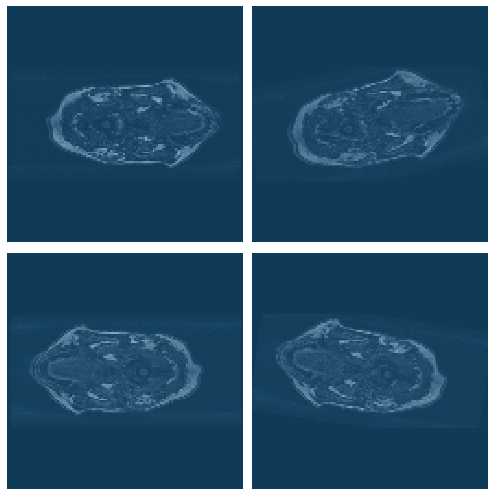

In [18]:
data.show_batch(2, figsize=(7,7))

In [19]:
# load a model
wd=1e-2
learn = unet_learner(data, models.resnet34, metrics=dice, wd=wd)
learn.load('3.01_02_train-axial_bias_uf_foc-20_lr-1e3_sp-all');

### Create an empty arrrays for results (fsl_128, pred_128, x_128)

In [20]:
%%time
create = 1
if create:
    # tworzymy macierze z obrazami
    n = len(learn.data.valid_dl.dataset.items)
    fsl_128 = np.zeros((n, 128, 128), dtype=np.uint8)
    pred_128 = np.zeros((n, 128, 128), dtype=np.uint8)
    x_128 = np.zeros((n, 128, 128), dtype=np.float32)

CPU times: user 2.13 ms, sys: 173 µs, total: 2.3 ms
Wall time: 1.95 ms


### Fill in arrays with 2D images

In [21]:
%%time
# Fill in fsl_128 and pred_128 with label and prediction
fillin = 1
if fillin:
    k = 0
    for k in range(n):
        x,y = learn.data.valid_ds[k]  
        p,_,_ = learn.predict(x)

        fsl_128[k,:,:] = np.squeeze(to_np(y))
        x_128[k,:,:] = np.squeeze(to_np(x))
        pred_128[k,:,:] = np.squeeze(to_np(p))  
        print(f'{k:06}/{n}', end='\r')
        k += 1

CPU times: user 6min 35s, sys: 13.4 s, total: 6min 48s
Wall time: 12.8 s


### Save predictinos to a disc

In [22]:
%%time
save1 = 1
if save1:  
    # create a df with all 2d filenames
    full_names = list(learn.data.valid_dl.items)
    mask_full_path=list(df_main.msk)
    # save matrix with predictions to npz file
    # save uncompressed 
    save_name = f'3.01_{PLANE_NAME}_{IMAGET_TYPE}_uncompressed_results'
    save_pth = MAIN_PTH / save_name
    np.savez(save_pth, full_names=full_names, fsl_128=fsl_128, pred_128=pred_128, x_128=x_128, mask_full_path=mask_full_path)
    print(save_pth)

/data-10tb/shared/skull/al-image/3.01_axial_t1_uncompressed_results
CPU times: user 1.56 s, sys: 124 ms, total: 1.68 s
Wall time: 52.6 ms


### DICE / JACCARD

In [23]:
def dice(im1, im2):
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)
    return 2. * intersection.sum() / (im1.sum() + im2.sum())

In [24]:
%%time

# Get a 3D images of a single patient (e.g. 170x128x128)
xP = x_128   
yP = fsl_128  
pP = pred_128  

dice_jaccard_hausdorff = 'DJH'

if 'D' in dice_jaccard_hausdorff:
    dice_c = dice(yP.flat[:], pP.flat[:])
    print(f'Dice = {dice_c:.4f}')

if 'J' in dice_jaccard_hausdorff:
    jaccard_c = jaccard_score(yP.flat[:], pP.flat[:])
    print(f'Jaccard = {jaccard_c:.4f}')

# how to calculate it? what metric? total sum?
if 'H' in dice_jaccard_hausdorff:
    sh = xP.shape[0]
    h = np.zeros(sh)
    for kk in range(sh):
        h[kk] = directed_hausdorff(yP[kk,:,:], pP[kk,:,:])[0]
    print(f'Hausdorf sum = {h.sum():.4f}')
    print(f'Hausdorf sum = {h.mean():.4f}')
print()

Dice = 0.9235
Jaccard = 0.8579
Hausdorf sum = 397.3515
Hausdorf sum = 2.1953

CPU times: user 34.3 s, sys: 1.59 s, total: 35.9 s
Wall time: 1.2 s


(2965504,)

(2965504,)